In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [411]:
gas = ct.Solution("seiser.cti")
# gas.Y = np.array([0.5, 0, 0.5, 0, 0])
# gas.TP = 1200, 101325
# reactor = ct.IdealGasReactor(gas)
# sim = ct.ReactorNet([reactor])
# sim.advance(5.93e-6)
#gas.Y = np.array([0.25, 0.25, 0.25, 0.25, 0, 0])
gas.Y = np.ones(gas.n_species) / gas.n_species
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
gas.TP = 1200, 101325
np.save("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy", gas.Y)
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
gas()



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767

  gas:

       temperature            1200  K
          pressure          101325  Pa
           density        0.377851  kg/m^3
  mean mol. weight         37.2066  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      4.1341e+06        1.538e+08     J
   internal energy      3.8659e+06        1.438e+08     J
           entropy           10684        3.975e+05     J/K
    Gibbs function     -8.6872e+06       -3.232e+08     J
 heat capacity c_p          3280.6        1.221e+05     J/K
 heat capacity c_v          3057.2        1.137e+05     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2     0.00

/home/darve/adncat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  """Entry point for launching an IPython kernel.


In [412]:
gas.density

0.3778511846534872

In [413]:
#gas.TP = 1200, 101325
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
reactor = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([reactor])
n_t = 200
Pt = np.zeros(n_t)
Tt = np.zeros(n_t)
Yt = np.zeros((gas.n_species,n_t))
for i in range(n_t):
    sim.advance((i+1)*1e-14)
    Pt[i] = gas.P
    Tt[i] = gas.T
    Yt[:,i] = gas.Y
gas()


  gas:

       temperature         1203.92  K
          pressure          102632  Pa
           density        0.377851  kg/m^3
  mean mol. weight         36.8526  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      4.1376e+06        1.525e+08     J
   internal energy      3.8659e+06        1.425e+08     J
           entropy           10723        3.952e+05     J/K
    Gibbs function     -8.7715e+06       -3.233e+08     J
 heat capacity c_p          3279.9        1.209e+05     J/K
 heat capacity c_v          3054.3        1.126e+05     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2     0.00822206          0.00625         -30.1405
               ch3      0.0165027       0.00673265         -16.4287
                 h       0.230328        0.0062996          4.92866
               ch4      0.01

In [414]:
Pt

array([101346.95739854, 101368.45910547, 101389.51563926, 101410.13727787,
       101430.33408094, 101450.11589669, 101469.49235212, 101488.47286349,
       101507.06664343, 101525.28270347, 101543.12985752, 101560.61671527,
       101577.75170078, 101594.54304943, 101610.99881168, 101627.12685727,
       101642.9348774 , 101658.4303887 , 101673.62073679, 101688.51309873,
       101703.11448872, 101717.43176129, 101731.47160607, 101745.24056338,
       101758.74502075, 101771.99121987, 101784.98525651, 101797.73308368,
       101810.24051474, 101822.51322617, 101834.55676174, 101846.37653473,
       101857.97783092, 101869.36581106, 101880.54551485, 101891.52186036,
       101902.2996526 , 101912.88357796, 101923.27821509, 101933.48803129,
       101943.51738723, 101953.37053989, 101963.05164347, 101972.56475318,
       101981.91382643, 101991.10272615, 102000.13522169, 102009.01499229,
       102017.74562832, 102026.33063318, 102034.7734264 , 102043.07734388,
       102051.24564182, 1

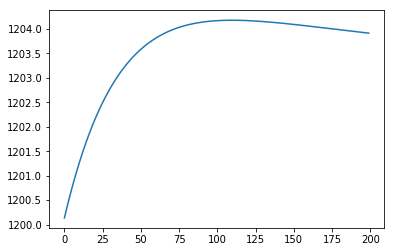

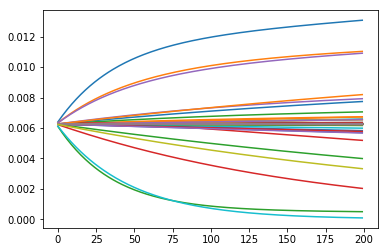

In [415]:
plt.plot(Tt)
plt.figure()
for i in range(gas.n_species):
    plt.plot(Yt[i,:])
####

In [416]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pressure.npy', Pt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature.npy', Tt)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/mass_fraction.npy', Yt)

In [309]:
tbd = []
falofr = []
elmr = []
for i in range(gas.n_reactions):
    if (isinstance(gas.reaction(i), ct.ThreeBodyReaction)):
        tbd.append(i)
    elif (isinstance(gas.reaction(i), ct.FalloffReaction)):
        falofr.append(i)
    else:
        elmr.append(i)

In [310]:
NASA_coeffs = []
for i in range(gas.n_species):
    NASA_coeffs.append(gas.species(i).thermo.coeffs)
NASA_coeffs = np.array(NASA_coeffs)
reactants = []
orders = [] 
Af = np.zeros(len(elmr))
beta = np.zeros(len(elmr))
E = np.zeros(len(elmr))

In [311]:
rec2ind = dict()
for i in range(gas.n_species):
    reactants.append(gas.species(i).name)
    rec2ind[gas.species(i).name] = i
orders = gas.reactant_stoich_coeffs()[:,elmr]
for i, s in enumerate(elmr):   
    Af[i] = gas.reaction(s).rate.pre_exponential_factor
    beta[i] = gas.reaction(s).rate.temperature_exponent
    E[i] = gas.reaction(s).rate.activation_energy
    for rec in gas.reaction(s).orders:
        orders[rec2ind[rec], i] = gas.reaction(s).orders[rec]
reversible = np.array([int(gas.reaction(i).reversible) for i in range(gas.n_reactions)])

In [312]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/NASA_coeffs.npy', NASA_coeffs)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/molecular_weights.npy',gas.molecular_weights)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reactants_stoich_coeffs.npy',gas.reactant_stoich_coeffs())
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/product_stoich_coeffs.npy',gas.product_stoich_coeffs())
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders.npy',orders)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy', Af)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy', beta)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy', E)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/delta_standard_entropy.npy', gas.delta_standard_entropy)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/delta_standard_enthalpy.npy', gas.delta_standard_enthalpy)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reversible.npy', reversible)

In [313]:
efficiency_f = np.zeros((gas.n_species, len(falofr)))
Af_lo = np.zeros(len(falofr))
beta_lo = np.zeros(len(falofr))
E_lo = np.zeros(len(falofr))
Af_hi = np.zeros(len(falofr))
beta_hi = np.zeros(len(falofr))
E_hi = np.zeros(len(falofr))
orders_f = gas.reactant_stoich_coeffs()[:,falofr]
falloff_parameters = np.zeros((4, len(falofr)))
troefall = []
troefall_coeff = []
for i, s in enumerate(falofr):
    rr = gas.reaction(s)
    Af_lo[i] = rr.low_rate.pre_exponential_factor
    beta_lo[i] = rr.low_rate.temperature_exponent
    E_lo[i] = rr.low_rate.activation_energy
    Af_hi[i] = rr.high_rate.pre_exponential_factor
    beta_hi[i] = rr.high_rate.temperature_exponent
    E_hi[i] = rr.high_rate.activation_energy
    efficiency_f[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    if(isinstance(rr.falloff, ct.TroeFalloff)):
        troefall.append(i)
        troefall_coeff.append(rr.falloff.parameters)
    #falloff_parameters[:,i] = gas.reaction(s).falloff.parameters
    for rec in rr.efficiencies:
        efficiency_f[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_f[rec2ind[rec], i] = gas.reaction(s).orders[rec]

np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/efficiency_f.npy', efficiency_f)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/troefall_coeff.npy', np.array(troefall_coeff).T)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/troefall.npy', troefall)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders_f.npy',orders_f)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy', Af_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy', beta_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy', E_hi)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy', Af_lo)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy', beta_lo)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy', E_lo)

In [314]:
efficiency_t = np.zeros((gas.n_species, len(tbd)))
Af_t = np.zeros(len(tbd))
beta_t = np.zeros(len(tbd))
E_t = np.zeros(len(tbd))
orders_t = gas.reactant_stoich_coeffs()[:,tbd]
for i, s in enumerate(tbd):
    rr = gas.reaction(s)
    Af_t[i] = rr.rate.pre_exponential_factor
    beta_t[i] = rr.rate.temperature_exponent
    E_t[i] = rr.rate.activation_energy
    efficiency_t[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    for rec in rr.efficiencies:
        efficiency_t[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_t[rec2ind[rec], i] = gas.reaction(s).orders[rec]
        
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/efficiency_t.npy',efficiency_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/reaction_orders_t.npy',orders_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy', Af_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy', beta_t)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy', E_t)

In [315]:
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy',tbd)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy',falofr)
np.save('/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy',elmr)

In [179]:
ai = gas.reaction(0).high_rate.pre_exponential_factor
bi = gas.reaction(0).high_rate.temperature_exponent
ei = gas.reaction(0).high_rate.activation_energy
kf_h = ai * (gas.T**bi) * np.exp(-ei/(ct.gas_constant * gas.T))
kf_h

125528192365.36696

In [188]:
ai = gas.reaction(0).low_rate.pre_exponential_factor
bi = gas.reaction(0).low_rate.temperature_exponent
ei = gas.reaction(0).low_rate.activation_energy
kf_o = ai * (gas.T**bi) * np.exp(-ei/(ct.gas_constant * gas.T)) * gas.concentrations.dot(efficiency_f[:,0])
kf_o

5979525284.376619

In [189]:
kf_o / (1 + kf_o / kf_h)

5707642209.63778

In [222]:
np.array(troefall_coeff).shape

(20, 4)

In [200]:
help(gas.reaction(0).falloff)

Help on TroeFalloff object:

class TroeFalloff(Falloff)
 |  The 3- or 4-parameter Troe falloff function.
 |  
 |  :param params:
 |      An array of 3 or 4 parameters: :math:`[a, T^{***}, T^*, T^{**}]` where
 |      the final parameter is optional (with a default value of 0).
 |  
 |  Method resolution order:
 |      TroeFalloff
 |      Falloff
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __reduce__ = __reduce_cython__(...)
 |      TroeFalloff.__reduce_cython__(self)
 |  
 |  __setstate__ = __setstate_cython__(...)
 |      TroeFalloff.__setstate_cython__(self, __pyx_state)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  falloff_type = 110
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Falloff:


In [206]:
gas.reaction().falloff.parameters

AttributeError: 'cantera._cantera.ElementaryReaction' object has no attribute 'falloff'

In [208]:
A = gas.reaction(falofr[10]).falloff.parameters
T = 1
A[0] + A[1] * T**3 + A[2] * T + A[3] * T**2

IndexError: index 0 is out of bounds for axis 0 with size 0

In [213]:
gas.reaction(falofr[1]).falloff